In [1]:
cd /content/drive/My Drive/PFV-master

/content/drive/My Drive/PFV-master


In [17]:
import torch
import numpy as np
import torch.nn as nn
import os, glob
from torchvision import transforms
from torchvision import models
from PIL import Image
from PFV import pfv
import matplotlib.pyplot as plt

In [18]:
# Embedding hook
embeddings = []
def feature_map_hook(module, input, output):
    embeddings.append(input[0])

In [19]:
def register_embedding_hooks_vgg(model):
    for i,module in enumerate(model.children()):
        # If the layer has children of its own, recursively traverse
        if list(module.children()): 
            register_embedding_hooks_vgg(module)
        # If a pooling layer, register a hook
        elif isinstance(module, nn.MaxPool2d):# or isinstance(module, nn.AdaptiveAvgPool2d):
            print(f"Registering hook to Layer ({i}) {module}")
            module.register_forward_hook(feature_map_hook)
        # If a strided convolution layer, register a hook
        elif isinstance(module, nn.Conv2d) and module.stride > (1,1):
                module.register_forward_hook(feature_map_hook)        
        elif isinstance(module, nn.Conv2d):
            if module.stride > (1,1):
                module.register_forward_hook(feature_map_hook)

In [20]:
image_dir = './sample_images/'
image_files = glob.glob(image_dir + '*.jpg')
input_images = []
for f in image_files:
  input_images.append(Image.open(f))

In [21]:
input_images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3543x2362 at 0x7F4CDCFB4710>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x692 at 0x7F4CDCFB4AC8>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3000x1696 at 0x7F4CDCFB4208>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3000x2315 at 0x7F4CDCFB40F0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1066x736 at 0x7F4CDCFB4E80>]

In [22]:
input_image = input_images
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
input_tensor = []
for image in input_images:
    input_tensor.append(preprocess(image))
input_batch = torch.stack(input_tensor)

In [24]:
# Initialize model
model = models.vgg16(pretrained=True)#Here you can add more models 
# Register embedding hooks
register_embedding_hooks_vgg(model)

Registering hook to Layer (4) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Registering hook to Layer (9) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Registering hook to Layer (16) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Registering hook to Layer (23) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Registering hook to Layer (30) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [25]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [26]:
with torch.no_grad():
    output = model(input_batch)

In [27]:
# Extract visualisation
vis = pfv(embeddings, image_shape=input_batch.shape[-2:], idx_layer=len(embeddings)-1, hierarchical=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [28]:
def concat(imgs, f=lambda x: x):
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    l = [f(imgs[i,:,:,:]) for i in range(imgs.shape[0])]
    return np.concatenate(l, axis=1)

In [29]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())

In [30]:
imgs = input_batch.detach().cpu().numpy()
orig_imgs = concat(imgs, normalize)
vis_imgs = concat(vis)

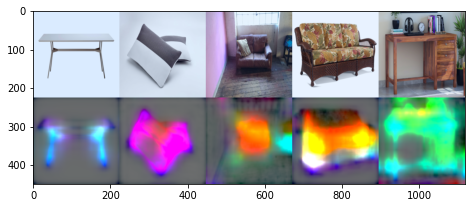

In [31]:
# Make a mosaic of original and visualization images
fig = np.concatenate([orig_imgs] + [vis_imgs])
img = np.zeros((224, 224, 3), dtype=np.uint8)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.imshow(fig)
plt.savefig('i.png', bbox_inches='tight')
plt.show()